In [5]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
}

In [6]:
## Build the team name to team_id map
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1

In [7]:
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import winprobabilitypbp

In [72]:
def plot_game_win_probability(win_probability, title):
    home_pct = win_probability['HOME_PCT'].values
    visit_pct = win_probability['VISITOR_PCT'].values
    mode = 'game'
    ind = range(len(home_pct))
    baseline = [0.5] * len(home_pct)
    plt.plot(ind, home_pct, 'g.')
    plt.plot(ind, visit_pct, 'r^')
    plt.plot(ind, baseline, 'k-')
    plt.title(title)
    if '@' in title:
        plt.legend((title[-3:], title[:3]))
    else:
        plt.legend((title[:3], title[-3:]))
    
    if mode == 'game':
        game_pct = np.abs(home_pct - visit_pct)
        game_inflection = get_inflection_point_occurences(game_pct, 2)
        game_values = game_pct[game_inflection[0:10]]
        
        plt.plot(game_inflection[0:10], game_values, 'bX', markersize=20)
        
        print("Game important plays: ")
        get_influential_plays(win_probability, game_inflection)
    else:
        home_inflection = get_inflection_point_occurences(home_pct, 1)
        visit_inflection = get_inflection_point_occurences(visit_pct, 1)
        hi_values = home_pct[home_inflection[0:10]]
        vi_values = visit_pct[visit_inflection[0:10]]

        plt.plot(home_inflection[0:10], hi_values, 'bX', markersize=20)
        plt.plot(visit_inflection[0:10], vi_values, 'y*', markersize=20)

        print("Home team important plays: ")
        get_influential_plays(win_probability, home_inflection)

        print("Visiting team important plays: ")
        get_influential_plays(win_probability, visit_inflection)       
    plt.show()

In [73]:
def generate_win_probability_team(team):
    gpbp = teamgamelog.TeamGameLog(team_id=team_to_id[team], headers=headers)
    tgl = gpbp.get_data_frames()[0]
    games = tgl['Game_ID'].values
    matchups = tgl['MATCHUP'].values
    i = 0
    for game in games:
        wpp = winprobabilitypbp.WinProbabilityPBP(game_id=game, headers=headers)
        wp = wpp.get_data_frames()[0]
        plot_game_win_probability(wp, matchups[i])
        i += 1

In [74]:
def get_inflection_point_occurences(team_data, derivative_type):
    second_deriv = np.diff(team_data, n=derivative_type).tolist()
    second_deriv_sorted = sorted(second_deriv, reverse=True)
    inflection_occurences = []
    for i in second_deriv_sorted:
        inflection_occurences.append(second_deriv.index(i) + 2)
    return inflection_occurences    

def get_influential_plays(wp, inflection_occurences):
    number = 10
    events = wp['EVENT_NUM'].values
    descriptions = wp['DESCRIPTION'].values
    quarter = wp['PERIOD'].values
    time_in_quarter = wp['SECONDS_REMAINING'].values
    
    event_inflect = events[inflection_occurences]
    desc_inflect = descriptions[inflection_occurences]
    quarter_inflect = quarter[inflection_occurences]
    tiq_inflect = time_in_quarter[inflection_occurences]

    print("Top turning point descriptions: ")
    for i in range(len(desc_inflect)):
        d = desc_inflect[i]
        if d is not None:
            number = number - 1
            print('With %s seconds left in quarter %s: %s' % (tiq_inflect[i], quarter_inflect[i], d))
        if number <= 0:
            break
    print("Done")

Game important plays: 
Top turning point descriptions: 
With 21.0 seconds left in quarter 4: Butler Free Throw 2 of 3 (25 PTS)
With 17.0 seconds left in quarter 4: Barrett REBOUND (Off:0 Def:5)
With 2.0 seconds left in quarter 4: Butler Bad Pass Turnover (P1.T15)#@#Barrett STEAL (2 STL)
With 338.0 seconds left in quarter 4: Robinson  3PT Jump Shot (11 PTS) (Adebayo 3 AST)
With 356.0 seconds left in quarter 4: Heat Timeout: Regular (Reg.5 Short 0)
With 98.0 seconds left in quarter 4: Gibson Free Throw 2 of 2 (14 PTS)
With 136.0 seconds left in quarter 4: Randle 25' 3PT Jump Shot (22 PTS) (Payton 5 AST)
With 308.0 seconds left in quarter 4: Nunn 24' 3PT Jump Shot (20 PTS) (Adebayo 4 AST)
With 587.0 seconds left in quarter 4: Herro 26' 3PT Jump Shot (15 PTS) (Dragic 4 AST)
With 323.0 seconds left in quarter 4: SUB: Johnson FOR Herro
Done


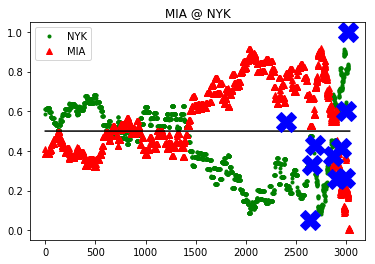

Game important plays: 
Top turning point descriptions: 
With 217.0 seconds left in quarter 4: Heat Timeout: Regular (Reg.4 Short 0)
With 25.0 seconds left in quarter 4: Prince 1' Floating Jump Shot (17 PTS) (Harris 6 AST)
With 536.0 seconds left in quarter 4: Johnson 27' 3PT Jump Shot (3 PTS) (Herro 4 AST)
With 54.0 seconds left in quarter 4: LeVert REBOUND (Off:2 Def:1)
With 99.0 seconds left in quarter 4: Jones Jr. REBOUND (Off:0 Def:4)
With 435.0 seconds left in quarter 4: Johnson 26' 3PT Jump Shot (6 PTS) (Dragic 5 AST)
With 574.0 seconds left in quarter 4: Jones Jr. 3' Cutting Layup Shot (6 PTS) (Herro 3 AST)
With 94.0 seconds left in quarter 3: Dragic 5' Finger Roll Layup (11 PTS)
With 153.0 seconds left in quarter 3: Heat Timeout: Regular (Reg.3 Short 0)
With 207.0 seconds left in quarter 3: Butler 11' Floating Jump Shot (25 PTS) (Dragic 4 AST)
Done


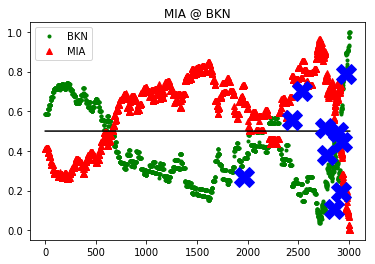

Game important plays: 
Top turning point descriptions: 
With 179.0 seconds left in quarter 2: Dragic 26' 3PT Pullup Jump Shot (6 PTS)
With 307.0 seconds left in quarter 1: Sabonis 1' Putback Layup (4 PTS)
With 364.0 seconds left in quarter 2: Herro 26' 3PT Step Back Jump Shot (9 PTS) (Robinson 3 AST)
With 432.0 seconds left in quarter 2: Jones Jr.  3PT Jump Shot (5 PTS) (Herro 1 AST)
With 555.0 seconds left in quarter 2: Herro 26' 3PT Jump Shot (6 PTS) (Dragic 2 AST)
With 690.0 seconds left in quarter 2: Herro 30' 3PT Pullup Jump Shot (3 PTS) (Leonard 1 AST)
With 687.0 seconds left in quarter 3: Nunn 24' 3PT Jump Shot (9 PTS) (Leonard 2 AST)
With 109.0 seconds left in quarter 2: Adebayo 3' Driving Layup (10 PTS)
With 399.0 seconds left in quarter 2: Dragic 2' Layup (3 PTS) (Adebayo 2 AST)
With 333.0 seconds left in quarter 1: Robinson  3PT Pullup Jump Shot (6 PTS)
Done


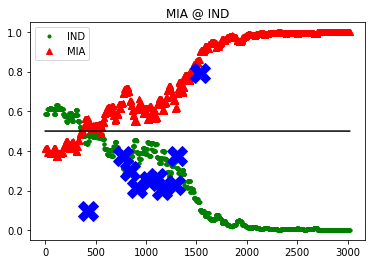

Game important plays: 
Top turning point descriptions: 
With 161.0 seconds left in quarter 3: Jones Jr. 26' 3PT Step Back Jump Shot (15 PTS)
With 128.0 seconds left in quarter 3: Dragic 27' 3PT Jump Shot (17 PTS) (Herro 1 AST)
With 694.0 seconds left in quarter 4: Dragic 26' 3PT Jump Shot (20 PTS) (Adebayo 6 AST)
With 109.0 seconds left in quarter 1: Dragic 26' 3PT Jump Shot (5 PTS) (Leonard 2 AST)
With 289.0 seconds left in quarter 1: Johnson  3PT Jump Shot (3 PTS) (Leonard 1 AST)
With 675.0 seconds left in quarter 2: Herro 26' 3PT Pullup Jump Shot (5 PTS)
With 683.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:1)
With 662.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 463.0 seconds left in quarter 1: Leonard 27' 3PT Jump Shot (3 PTS) (Nunn 1 AST)
With 576.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:2)
Done


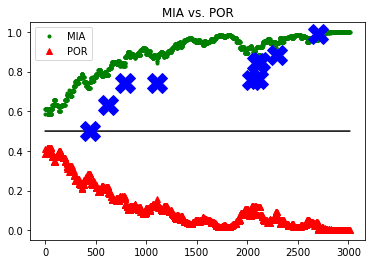

Game important plays: 
Top turning point descriptions: 
With 230.0 seconds left in quarter 3: Iwundu 24' 3PT Jump Shot (3 PTS) (Augustin 4 AST)
With 489.0 seconds left in quarter 2: Ross 26' 3PT Jump Shot (13 PTS) (Augustin 2 AST)
With 0.0 seconds left in quarter 3: Heat Rebound
With 87.0 seconds left in quarter 3: Ross 26' 3PT Pullup Jump Shot (25 PTS) (Augustin 5 AST)
With 82.0 seconds left in quarter 1: Bamba REBOUND (Off:1 Def:1)
With 692.0 seconds left in quarter 3: Butler 16' Turnaround Jump Shot (16 PTS)
With 126.0 seconds left in quarter 1: Ross 26' 3PT Pullup Jump Shot (6 PTS)
With 58.0 seconds left in quarter 1: Ross 26' 3PT Jump Shot (9 PTS) (Augustin 1 AST)
With 691.0 seconds left in quarter 2: Iwundu REBOUND (Off:2 Def:0)
With 304.0 seconds left in quarter 3: Vucevic 3' Driving Hook Shot (18 PTS) (Fultz 3 AST)
Done


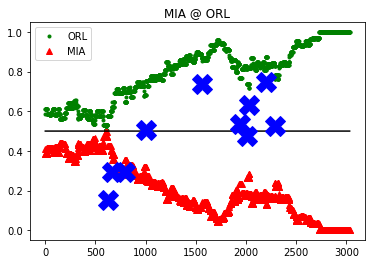

Game important plays: 
Top turning point descriptions: 
With 626.0 seconds left in quarter 4: Boucher 1' Putback Layup (2 PTS)
With 577.0 seconds left in quarter 4: Herro 26' 3PT Jump Shot (10 PTS) (Nunn 6 AST)
With 27.0 seconds left in quarter 3: Herro 24' 3PT Jump Shot (5 PTS) (Nunn 5 AST)
With 395.0 seconds left in quarter 3: Nunn 26' 3PT Jump Shot (7 PTS) (Butler 6 AST)
With 528.0 seconds left in quarter 4: Herro 26' 3PT Pullup Jump Shot (13 PTS) (Adebayo 2 AST)
With 273.0 seconds left in quarter 4: Jones Jr. 24' 3PT Jump Shot (6 PTS) (Nunn 8 AST)
With 216.0 seconds left in quarter 3: HEAT Timeout: Regular (Full 3 Short 0)
With 259.0 seconds left in quarter 3: Robinson  3PT Jump Shot (6 PTS) (Butler 7 AST)
With 0.0 seconds left in quarter 2: Instant Replay2nd Period (8:37 PM EST)
With 330.0 seconds left in quarter 2: Dragic 25' 3PT Jump Shot (8 PTS) (Butler 3 AST)
Done


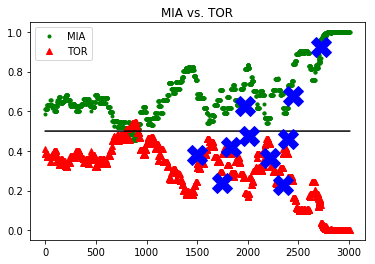

Game important plays: 
Top turning point descriptions: 
With 149.0 seconds left in quarter 2: Mathews 26' 3PT Jump Shot (20 PTS) (Thomas 4 AST)
With 315.0 seconds left in quarter 2: Mathews 26' 3PT Jump Shot (14 PTS) (McRae 5 AST)
With 259.0 seconds left in quarter 2: Mathews 26' 3PT Jump Shot (17 PTS) (Smith 5 AST)
With 5.0 seconds left in quarter 3: Smith 25' 3PT Pullup Jump Shot (9 PTS)
With 343.0 seconds left in quarter 2: McRae  3PT Jump Shot (20 PTS) (Brown Jr. 1 AST)
With 386.0 seconds left in quarter 2: Mathews Free Throw 1 of 3 (11 PTS)
With 403.0 seconds left in quarter 2: Adebayo REBOUND (Off:2 Def:2)
With 482.0 seconds left in quarter 3: Thomas 27' 3PT Jump Shot (3 PTS) (Payton II 1 AST)
With 68.0 seconds left in quarter 2: Silva 2' Layup (2 PTS)
With 59.0 seconds left in quarter 2: Smith 1' Driving Layup (4 PTS)
Done


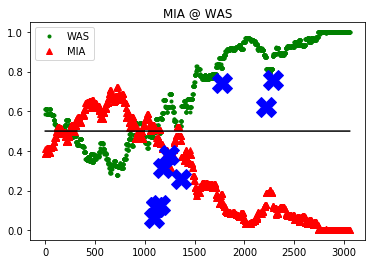

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: HEAT Timeout: Regular (Full 6 Short 0)
With 18.0 seconds left in quarter 5: HEAT Timeout: Regular (Full 7 Short 0)
With 171.0 seconds left in quarter 4: Richardson 26' 3PT Jump Shot (17 PTS)
With 100.0 seconds left in quarter 4: Butler Free Throw 1 of 1 (22 PTS)
With 3.0 seconds left in quarter 4: Embiid Lost Ball Turnover (P3.T9)#@#Butler STEAL (2 STL)
With 0.0 seconds left in quarter 4: Simmons REBOUND (Off:3 Def:3)
With 74.0 seconds left in quarter 4: Embiid 26' 3PT Step Back Jump Shot (33 PTS)
With 6.0 seconds left in quarter 4: 76ers Timeout: Regular (Reg.7 Short 0)
With 299.0 seconds left in quarter 2: Korkmaz REBOUND (Off:0 Def:3)
With 42.0 seconds left in quarter 4: 76ers Timeout: Regular (Reg.6 Short 0)
Done


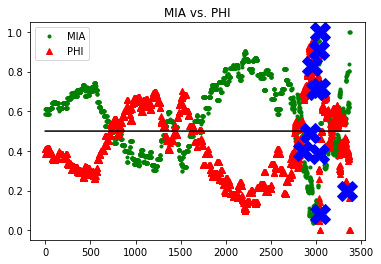

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: Pacers Rebound
With 261.0 seconds left in quarter 4: Turner 25' 3PT Jump Shot (13 PTS) (Holiday 9 AST)
With 70.0 seconds left in quarter 4: Butler Offensive Foul Turnover (P4.T13)
With 199.0 seconds left in quarter 4: Lamb 17' Pullup Jump Shot (14 PTS)
With 54.0 seconds left in quarter 4: Adebayo REBOUND (Off:5 Def:9)
With 537.0 seconds left in quarter 3: Robinson 26' 3PT Jump Shot (12 PTS) (Butler 5 AST)
With 235.0 seconds left in quarter 3: Nunn 25' 3PT Jump Shot (17 PTS) (Dragic 4 AST)
With 504.0 seconds left in quarter 3: Nunn  3PT Step Back Jump Shot (14 PTS) (Robinson 2 AST)
With 629.0 seconds left in quarter 3: Robinson 27' 3PT Jump Shot (9 PTS) (Adebayo 4 AST)
With 19.0 seconds left in quarter 2: Robinson 27' 3PT Jump Shot (6 PTS) (Adebayo 3 AST)
Done


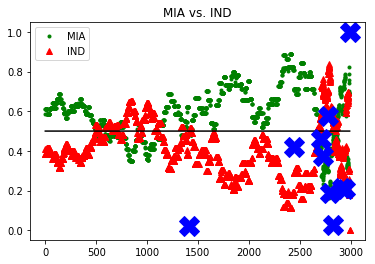

Game important plays: 
Top turning point descriptions: 
With 530.0 seconds left in quarter 4: Robinson 25' 3PT Jump Shot (3 PTS) (Adebayo 5 AST)
With 336.0 seconds left in quarter 3: Bogdanovic 1' Tip Layup Shot (12 PTS)
With 455.0 seconds left in quarter 4: Herro 27' 3PT Running Pull-Up Jump Shot (11 PTS)
With 473.0 seconds left in quarter 4: Adebayo REBOUND (Off:4 Def:7)
With 420.0 seconds left in quarter 2: Gobert 1' Putback Dunk (6 PTS)
With 591.0 seconds left in quarter 4: Gobert 3' Cutting Dunk Shot (12 PTS) (Mitchell 5 AST)
With 605.0 seconds left in quarter 4: Jazz Timeout: Regular (Reg.4 Short 0)
With 406.0 seconds left in quarter 4: Dragic  3PT Turnaround Jump Shot (13 PTS)
With 130.0 seconds left in quarter 3: Green 5' Running Layup (4 PTS) (Bogdanovic 1 AST)
With 474.0 seconds left in quarter 2: Herro 26' 3PT Jump Shot (3 PTS) (Olynyk 1 AST)
Done


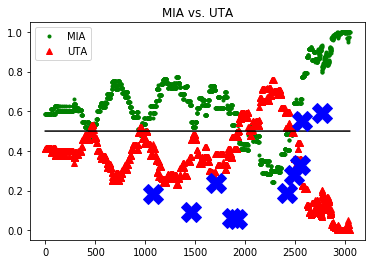

Game important plays: 
Top turning point descriptions: 
With 672.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 650.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 523.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:2)
With 538.0 seconds left in quarter 1: Robinson 25' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
With 472.0 seconds left in quarter 1: Robinson  3PT Jump Shot (6 PTS) (Butler 3 AST)
With 489.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:2)
With 577.0 seconds left in quarter 1: Nunn 26' 3PT Jump Shot (3 PTS) (Butler 2 AST)
With 261.0 seconds left in quarter 1: Butler 26' 3PT Jump Shot (5 PTS) (Nunn 2 AST)
With 422.0 seconds left in quarter 1: Ntilikina Out of Bounds - Bad Pass Turnover Turnover (P1.T1)
With 392.0 seconds left in quarter 1: Gibson Out of Bounds Lost Ball Turnover (P1.T2)
Done


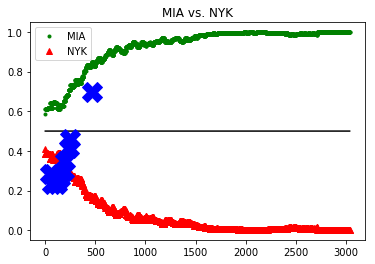

Game important plays: 
Top turning point descriptions: 
With 1.0 seconds left in quarter 4: Adebayo REBOUND (Off:3 Def:6)
With 37.0 seconds left in quarter 3: Nunn 27' 3PT Jump Shot (23 PTS) (Adebayo 2 AST)
With 228.0 seconds left in quarter 3: Heat Timeout: Regular (Reg.3 Short 0)
With 68.0 seconds left in quarter 4: Jones Jr. 28' 3PT Jump Shot (13 PTS) (Butler 5 AST)
With 581.0 seconds left in quarter 3: Leonard 26' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
With 365.0 seconds left in quarter 3: Leonard 26' 3PT Jump Shot (6 PTS) (Nunn 4 AST)
With 214.0 seconds left in quarter 2: 76ERS Timeout: Regular (Full 2 Short 0)
With 98.0 seconds left in quarter 2: Nunn 26' 3PT Running Pull-Up Jump Shot (13 PTS)
With 690.0 seconds left in quarter 3: Robinson 25' 3PT Jump Shot (7 PTS) (Butler 4 AST)
With 311.0 seconds left in quarter 3: Nunn 29' 3PT Jump Shot (20 PTS) (Leonard 2 AST)
Done


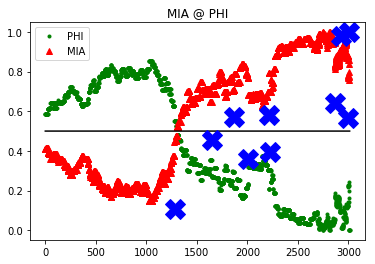

Game important plays: 
Top turning point descriptions: 
With 243.0 seconds left in quarter 4: Jackson Jr. 25' 3PT Jump Shot (15 PTS) (Melton 4 AST)
With 330.0 seconds left in quarter 4: Adebayo 1' Cutting Dunk Shot (14 PTS) (Butler 8 AST)
With 386.0 seconds left in quarter 4: GRIZZLIES Timeout: Regular (Full 5 Short 0)
With 261.0 seconds left in quarter 4: Melton REBOUND (Off:1 Def:2)
With 315.0 seconds left in quarter 4: Crowder REBOUND (Off:3 Def:0)
With 363.0 seconds left in quarter 1: Butler Free Throw 2 of 2 (2 PTS)
With 435.0 seconds left in quarter 4: GRIZZLIES Timeout: Regular (Full 4 Short 0)
With 183.0 seconds left in quarter 4: Clarke 2' Reverse Layup (14 PTS) (Crowder 2 AST)
With 314.0 seconds left in quarter 4: Crowder 1' Reverse Layup (8 PTS)
With 600.0 seconds left in quarter 4: MISS Nunn 9' Driving Floating Jump Shot#@#Jones BLOCK (1 BLK)
Done


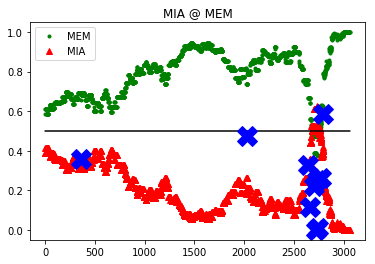

Game important plays: 
Top turning point descriptions: 
With 30.0 seconds left in quarter 4: Instant Replay4th Period (10:53 PM EST)
With 30.0 seconds left in quarter 4: MAVERICKS Timeout: Regular (Full 6 Short 0)
With 10.0 seconds left in quarter 5: Butler REBOUND (Off:1 Def:3)
With 42.0 seconds left in quarter 5: Butler REBOUND (Off:1 Def:2)
With 115.0 seconds left in quarter 5: Instant Replay1st OT (11:07 PM EST)
With 239.0 seconds left in quarter 4: Porzingis 26' 3PT Jump Shot (21 PTS) (Kleber 3 AST)
With 30.0 seconds left in quarter 4: Brunson L.B.FOUL (P4.PN) (S.Foster)
With 184.0 seconds left in quarter 5: Brunson 26' 3PT Pullup Jump Shot (18 PTS)
With 138.0 seconds left in quarter 5: Porzingis L.B.FOUL (P4.T2) (B.Nansel)
With 68.0 seconds left in quarter 4: Brunson 1' Driving Finger Roll Layup (15 PTS)
Done


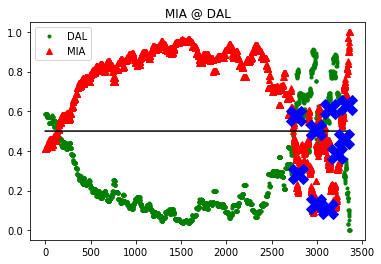

Game important plays: 
Top turning point descriptions: 
With 98.0 seconds left in quarter 4: Davis  3PT Jump Shot (32 PTS) (James 12 AST)
With 8.0 seconds left in quarter 4: Robinson Personal Take Foul (P3.PN) (G.Petraitis)
With 605.0 seconds left in quarter 4: Dudley 24' 3PT Jump Shot (3 PTS) (James 8 AST)
With 8.0 seconds left in quarter 4: Caldwell-Pope Free Throw 1 of 2 (14 PTS)
With 697.0 seconds left in quarter 4: James 26' 3PT Jump Shot (24 PTS) (Dudley 3 AST)
With 501.0 seconds left in quarter 3: HEAT Timeout: Regular (Full 3 Short 0)
With 410.0 seconds left in quarter 3: Davis 24' 3PT Jump Shot (23 PTS) (James 6 AST)
With 226.0 seconds left in quarter 4: James 1' Driving Layup (28 PTS)
With 286.0 seconds left in quarter 4: Caldwell-Pope  3PT Jump Shot (13 PTS) (James 10 AST)
With 4.0 seconds left in quarter 4: HEAT Timeout: Regular (Full 6 Short 0)
Done


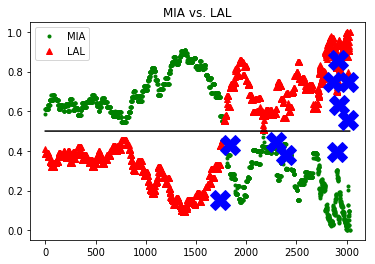

Game important plays: 
Top turning point descriptions: 
With 29.0 seconds left in quarter 4: Hawks Timeout: Regular (Reg.6 Short 0)
With 126.0 seconds left in quarter 4: Parker 2' Dunk (16 PTS) (Hunter 3 AST)
With 255.0 seconds left in quarter 4: Hunter 1' Driving Dunk (28 PTS) (Len 1 AST)
With 519.0 seconds left in quarter 4: Hunter 25' 3PT Jump Shot (22 PTS) (Crabbe 2 AST)
With 95.0 seconds left in quarter 4: Young 1' Driving Layup (21 PTS)
With 166.0 seconds left in quarter 4: Adebayo REBOUND (Off:2 Def:5)
With 646.0 seconds left in quarter 4: Crabbe  3PT Jump Shot (7 PTS) (Hunter 2 AST)
With 230.0 seconds left in quarter 5: Jones Jr. 2' Alley Oop Dunk (8 PTS) (Robinson 3 AST)
With 0.0 seconds left in quarter 4: HEAT Rebound
With 216.0 seconds left in quarter 5: Adebayo REBOUND (Off:3 Def:6)
Done


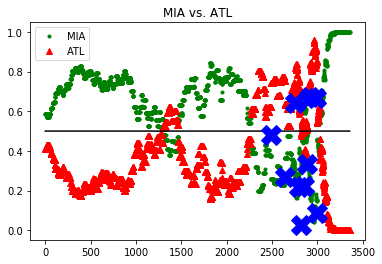

Game important plays: 
Top turning point descriptions: 
With 131.0 seconds left in quarter 4: Carter Jr. S.FOUL (P4.PN) (C.Washington)
With 7.0 seconds left in quarter 4: Herro 27' 3PT Jump Shot (16 PTS) (Butler 4 AST)
With 32.0 seconds left in quarter 4: LaVine REBOUND (Off:0 Def:5)
With 228.0 seconds left in quarter 5: Dunn REBOUND (Off:0 Def:5)
With 15.0 seconds left in quarter 4: HEAT Timeout: Regular (Full 6 Short 0)
With 252.0 seconds left in quarter 5: LaVine 2' Cutting Dunk Shot (18 PTS) (Dunn 2 AST)
With 15.0 seconds left in quarter 4: MISS LaVine 8' Driving Layup
With 84.0 seconds left in quarter 4: LaVine Free Throw 2 of 2 (14 PTS)
With 0.0 seconds left in quarter 4: HEAT Rebound
With 73.0 seconds left in quarter 4: Herro 2' Driving Layup (13 PTS) (Butler 3 AST)
Done


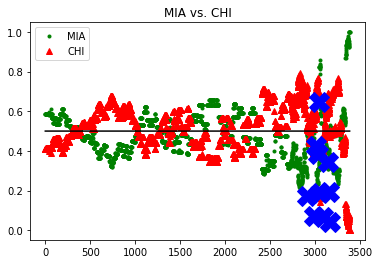

Game important plays: 
Top turning point descriptions: 
With 71.0 seconds left in quarter 2: Herro  3PT Fadeaway Jumper (13 PTS) (Butler 7 AST)
With 349.0 seconds left in quarter 2: Bertans 25' 3PT Jump Shot (12 PTS) (Beal 3 AST)
With 651.0 seconds left in quarter 2: Bertans 26' 3PT Pullup Jump Shot (6 PTS) (Chiozza 2 AST)
With 624.0 seconds left in quarter 2: Bertans 26' 3PT Pullup Jump Shot (9 PTS) (Brown Jr. 2 AST)
With 233.0 seconds left in quarter 2: Wagner 1' Layup (11 PTS) (Beal 4 AST)
With 105.0 seconds left in quarter 2: Wizards Timeout: Regular (Reg.3 Short 0)
With 303.0 seconds left in quarter 2: Wagner 1' Driving Layup (9 PTS)
With 38.0 seconds left in quarter 2: Butler Free Throw 1 of 2 (15 PTS)
With 668.0 seconds left in quarter 2: Olynyk S.FOUL (P2.T1) (L.Richardson)
With 384.0 seconds left in quarter 2: Smith 1' Driving Finger Roll Layup (8 PTS)
Done


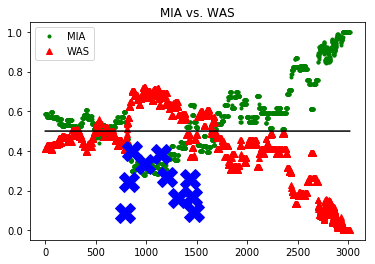

Game important plays: 
Top turning point descriptions: 
With 104.0 seconds left in quarter 2: Tatum 25' 3PT Step Back Jump Shot (13 PTS) (Walker 2 AST)
With 144.0 seconds left in quarter 3: Ojeleye  3PT Jump Shot (5 PTS) (Wanamaker 3 AST)
With 106.0 seconds left in quarter 3: Brown  3PT Jump Shot (21 PTS)
With 38.0 seconds left in quarter 2: Brown 24' 3PT Jump Shot (9 PTS) (Walker 3 AST)
With 172.0 seconds left in quarter 2: Leonard P.FOUL (P2.PN) (K.Lane)
With 631.0 seconds left in quarter 2: Herro 25' 3PT Step Back Jump Shot (3 PTS)
With 450.0 seconds left in quarter 3: Walker 27' 3PT Pullup Jump Shot (22 PTS)
With 318.0 seconds left in quarter 2: Olynyk 14' Turnaround Fadeaway (4 PTS)
With 74.0 seconds left in quarter 2: Walker 3' Driving Finger Roll Layup (17 PTS)
With 144.0 seconds left in quarter 2: Walker Free Throw 1 of 2 (14 PTS)
Done


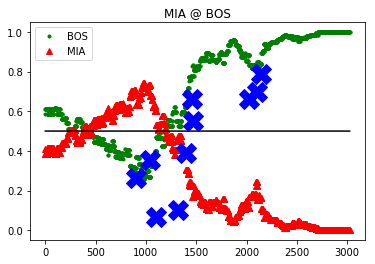

Game important plays: 
Top turning point descriptions: 
With 42.0 seconds left in quarter 4: Instant Replay4th Period (9:51 PM EST)
With 622.0 seconds left in quarter 2: Ibaka 1' Tip Layup Shot (2 PTS)
With 84.0 seconds left in quarter 5: Nunn Offensive Foul Turnover (P2.T13)
With 480.0 seconds left in quarter 2: Herro 27' 3PT Pullup Jump Shot (6 PTS)
With 75.0 seconds left in quarter 5: Adebayo REBOUND (Off:3 Def:3)
With 48.0 seconds left in quarter 2: Winslow 2' Turnaround Bank Hook Shot (6 PTS) (Butler 7 AST)
With 82.0 seconds left in quarter 4: Lowry Free Throw 2 of 2 (12 PTS)
With 224.0 seconds left in quarter 2: Olynyk 2' Reverse Layup (4 PTS) (Butler 4 AST)
With 301.0 seconds left in quarter 2: Adebayo 2' Reverse Layup (8 PTS)
With 619.0 seconds left in quarter 3: Siakam Free Throw 1 of 2 (11 PTS)
Done


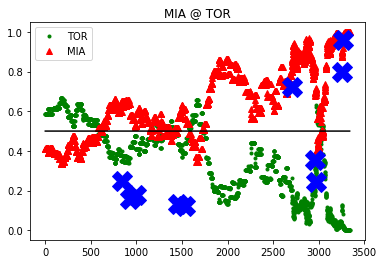

Game important plays: 
Top turning point descriptions: 
With 11.0 seconds left in quarter 4: Winslow Free Throw 1 of 2 (10 PTS)
With 11.0 seconds left in quarter 4: Winslow REBOUND (Off:2 Def:3)
With 400.0 seconds left in quarter 4: Harris 25' 3PT Step Back Jump Shot (19 PTS) (Prince 4 AST)
With 362.0 seconds left in quarter 4: Harris 25' 3PT Pullup Jump Shot (22 PTS) (Allen 2 AST)
With 594.0 seconds left in quarter 4: Temple REBOUND (Off:1 Def:4)
With 29.0 seconds left in quarter 4: Butler Free Throw 2 of 2 (20 PTS)
With 67.0 seconds left in quarter 4: Butler Free Throw 2 of 2 (17 PTS)
With 11.0 seconds left in quarter 4: Winslow Free Throw 2 of 2 (10 PTS)
With 96.0 seconds left in quarter 4: Dragic Free Throw 1 of 1 (24 PTS)
With 198.0 seconds left in quarter 4: Prince REBOUND (Off:2 Def:5)
Done


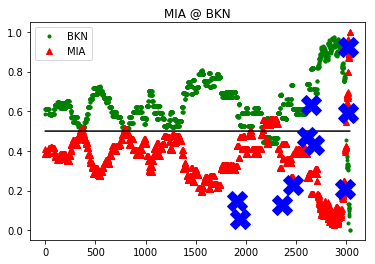

Game important plays: 
Top turning point descriptions: 
With 259.0 seconds left in quarter 3: Herro  3PT Jump Shot (13 PTS) (Butler 6 AST)
With 488.0 seconds left in quarter 3: Robinson 25' 3PT Jump Shot (17 PTS) (Adebayo 2 AST)
With 322.0 seconds left in quarter 2: Poole Free Throw 2 of 2 (11 PTS)
With 256.0 seconds left in quarter 2: Cauley-Stein 1' Tip Dunk Shot (2 PTS)
With 352.0 seconds left in quarter 2: Nunn  3PT Jump Shot (9 PTS) (Butler 5 AST)
With 161.0 seconds left in quarter 2: Cauley-Stein Bad Pass Turnover (P1.T2)#@#Olynyk STEAL (1 STL)
With 683.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 614.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 431.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 1 Short 0)
With 208.0 seconds left in quarter 1: Herro 24' 3PT Jump Shot (3 PTS) (Dragic 1 AST)
Done


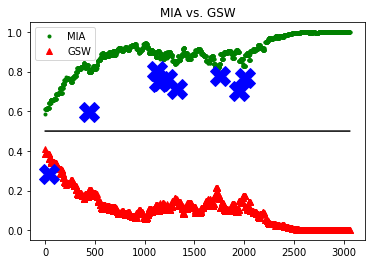

Game important plays: 
Top turning point descriptions: 
With 610.0 seconds left in quarter 2: Clark 25' 3PT Jump Shot (5 PTS) (Westbrook 4 AST)
With 348.0 seconds left in quarter 2: Harden 27' 3PT Jump Shot (16 PTS)
With 269.0 seconds left in quarter 1: Harden 28' 3PT Jump Shot (8 PTS) (Hartenstein 1 AST)
With 281.0 seconds left in quarter 1: ROCKETS Timeout: Regular (Full 1 Short 0)
With 659.0 seconds left in quarter 1: ROCKETS Rebound
With 626.0 seconds left in quarter 1: Westbrook REBOUND (Off:1 Def:1)
With 593.0 seconds left in quarter 1: Harden REBOUND (Off:0 Def:1)
With 573.0 seconds left in quarter 1: Adebayo Out of Bounds - Bad Pass Turnover Turnover (P1.T1)
With 543.0 seconds left in quarter 1: Westbrook REBOUND (Off:1 Def:2)
With 636.0 seconds left in quarter 2: Clark 1' Cutting Dunk Shot (2 PTS) (Westbrook 3 AST)
Done


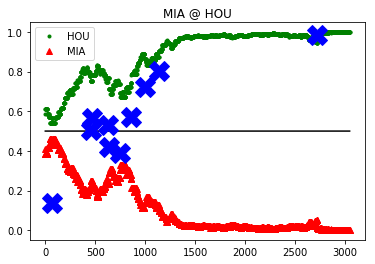

Game important plays: 
Top turning point descriptions: 
With 495.0 seconds left in quarter 2: Olynyk 26' 3PT Jump Shot (6 PTS) (Dragic 4 AST)
With 406.0 seconds left in quarter 2: Nunn 25' 3PT Jump Shot (9 PTS) (Butler 3 AST)
With 607.0 seconds left in quarter 2: Herro 27' 3PT Jump Shot (10 PTS) (Dragic 2 AST)
With 555.0 seconds left in quarter 2: Olynyk 25' 3PT Jump Shot (3 PTS) (Dragic 3 AST)
With 27.0 seconds left in quarter 1: Robinson 24' 3PT Jump Shot (6 PTS) (Olynyk 1 AST)
With 360.0 seconds left in quarter 2: Nunn 25' 3PT Pullup Jump Shot (12 PTS)
With 171.0 seconds left in quarter 1: Herro 26' 3PT Jump Shot (3 PTS) (Butler 2 AST)
With 263.0 seconds left in quarter 1: Robinson 24' 3PT Jump Shot (3 PTS) (Adebayo 3 AST)
With 521.0 seconds left in quarter 3: Graham Free Throw 2 of 3 (10 PTS)
With 436.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 1 Short 0)
Done


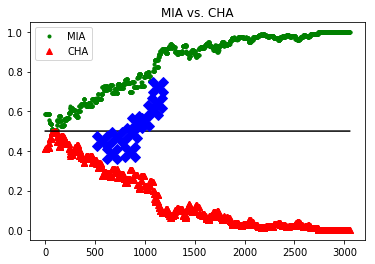

Game important plays: 
Top turning point descriptions: 
With 608.0 seconds left in quarter 1: Adebayo 1' Tip Layup Shot (2 PTS)
With 669.0 seconds left in quarter 1: Nunn Lost Ball Turnover (P1.T1)#@#Simmons STEAL (1 STL)
With 642.0 seconds left in quarter 1: Horford REBOUND (Off:0 Def:1)
With 582.0 seconds left in quarter 1: Simmons REBOUND (Off:0 Def:1)
With 559.0 seconds left in quarter 1: Simmons REBOUND (Off:0 Def:2)
With 526.0 seconds left in quarter 1: Harris REBOUND (Off:0 Def:1)
With 549.0 seconds left in quarter 1: Richardson 26' 3PT Jump Shot (3 PTS) (Horford 1 AST)
With 79.0 seconds left in quarter 1: Herro Out of Bounds Lost Ball Turnover (P1.T5)
With 297.0 seconds left in quarter 2: Horford 25' 3PT Jump Shot (9 PTS) (Simmons 5 AST)
With 432.0 seconds left in quarter 1: Simmons REBOUND (Off:0 Def:3)
Done


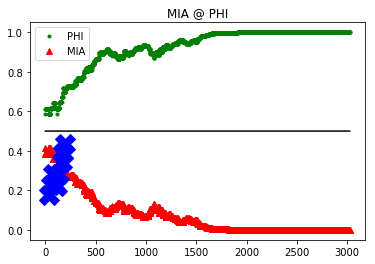

Game important plays: 
Top turning point descriptions: 
With 49.0 seconds left in quarter 1: Herro 26' 3PT Jump Shot (3 PTS) (Robinson 2 AST)
With 193.0 seconds left in quarter 1: Butler 25' 3PT Jump Shot (3 PTS) (Silva 1 AST)
With 293.0 seconds left in quarter 1: Nunn 24' 3PT Jump Shot (13 PTS) (Adebayo 3 AST)
With 157.0 seconds left in quarter 1: Dragic 25' 3PT Jump Shot (3 PTS) (Herro 1 AST)
With 400.0 seconds left in quarter 1: Leonard 25' 3PT Jump Shot (5 PTS) (Butler 3 AST)
With 705.0 seconds left in quarter 2: Dragic 25' 3PT Jump Shot (6 PTS) (Olynyk 1 AST)
With 588.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 516.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:2)
With 553.0 seconds left in quarter 1: Nunn REBOUND (Off:0 Def:2)
With 517.0 seconds left in quarter 1: MISS Markkanen 1' Tip Layup Shot
Done


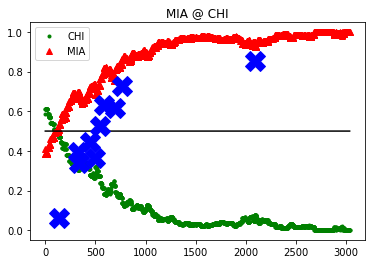

Game important plays: 
Top turning point descriptions: 
With 439.0 seconds left in quarter 1: Nance Jr. 1' Tip Dunk Shot (4 PTS)
With 688.0 seconds left in quarter 1: Nance Jr. 1' Tip Layup Shot (2 PTS)
With 327.0 seconds left in quarter 1: Robinson 26' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
With 490.0 seconds left in quarter 1: Sexton Free Throw 1 of 1 (3 PTS)
With 670.0 seconds left in quarter 2: Robinson 30' 3PT Jump Shot (6 PTS) (Herro 1 AST)
With 220.0 seconds left in quarter 1: Nunn 24' 3PT Step Back Jump Shot (7 PTS)
With 640.0 seconds left in quarter 1: HEAT Rebound
With 609.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:1)
With 708.0 seconds left in quarter 1: Garland Bad Pass Turnover (P1.T1)#@#Butler STEAL (1 STL)
With 646.0 seconds left in quarter 2: Herro  3PT Jump Shot (5 PTS) (Dragic 1 AST)
Done


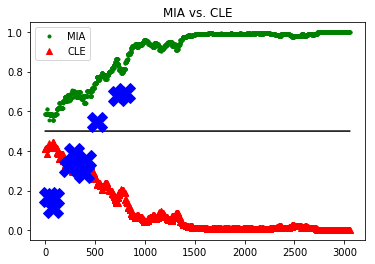

Game important plays: 
Top turning point descriptions: 
With 410.0 seconds left in quarter 3: Hayes 1' Tip Layup Shot (8 PTS)
With 241.0 seconds left in quarter 3: Butler 25' 3PT Jump Shot (10 PTS) (Silva 1 AST)
With 445.0 seconds left in quarter 3: Robinson  3PT Jump Shot (10 PTS) (Adebayo 2 AST)
With 178.0 seconds left in quarter 1: Hayes 1' Tip Dunk Shot (2 PTS)
With 460.0 seconds left in quarter 2: Olynyk 25' 3PT Jump Shot (3 PTS) (Robinson 1 AST)
With 366.0 seconds left in quarter 3: Leonard 2' Driving Layup (4 PTS)
With 519.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 2 Short 0)
With 543.0 seconds left in quarter 3: Nunn  Driving Dunk (13 PTS)
With 580.0 seconds left in quarter 3: Robinson 1' Running Layup (7 PTS)
With 0.0 seconds left in quarter 2: Adebayo 12' Floating Jump Shot (14 PTS) (Butler 8 AST)
Done


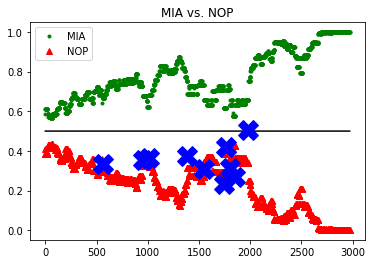

Game important plays: 
Top turning point descriptions: 
With 457.0 seconds left in quarter 2: Clarkson 1' Putback Layup (10 PTS)
With 0.0 seconds left in quarter 1: Dellavedova Free Throw 2 of 3 (3 PTS)
With 554.0 seconds left in quarter 2: Robinson 25' 3PT Jump Shot (6 PTS) (Adebayo 3 AST)
With 637.0 seconds left in quarter 2: Olynyk 27' 3PT Jump Shot (3 PTS) (Dragic 4 AST)
With 482.0 seconds left in quarter 2: Nunn 26' 3PT Jump Shot (12 PTS) (Adebayo 4 AST)
With 433.0 seconds left in quarter 2: Herro 26' 3PT Jump Shot (5 PTS) (Adebayo 5 AST)
With 422.0 seconds left in quarter 4: Heat Timeout: Regular (Reg.5 Short 0)
With 231.0 seconds left in quarter 1: Dragic 26' 3PT Jump Shot (3 PTS) (Nunn 3 AST)
With 388.0 seconds left in quarter 1: Sexton Free Throw 1 of 1 (5 PTS)
With 532.0 seconds left in quarter 2: Adebayo 2' Cutting Layup Shot (4 PTS) (Dragic 5 AST)
Done


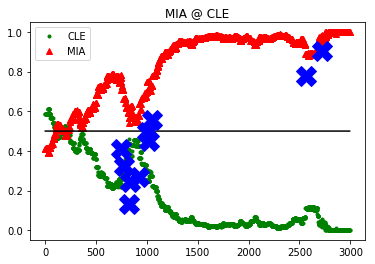

Game important plays: 
Top turning point descriptions: 
With 343.0 seconds left in quarter 4: Nunn 24' 3PT Jump Shot (18 PTS) (Butler 12 AST)
With 383.0 seconds left in quarter 4: SUB: Nunn FOR Robinson
With 697.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 541.0 seconds left in quarter 2: Dragic 25' 3PT Jump Shot (8 PTS) (Olynyk 2 AST)
With 630.0 seconds left in quarter 2: Dragic 26' 3PT Jump Shot (5 PTS) (Nunn 3 AST)
With 663.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:2)
With 615.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:3)
With 579.0 seconds left in quarter 1: Butler REBOUND (Off:0 Def:1)
With 196.0 seconds left in quarter 1: Frazier Bad Pass Turnover (P1.T4)#@#Butler STEAL (2 STL)
With 531.0 seconds left in quarter 1: Robinson  3PT Jump Shot (5 PTS) (Butler 2 AST)
Done


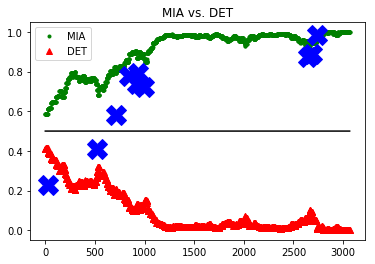

Game important plays: 
Top turning point descriptions: 
With 60.0 seconds left in quarter 2: Daniels 25' 3PT Jump Shot (3 PTS) (James 4 AST)
With 404.0 seconds left in quarter 2: Kuzma  3PT Jump Shot (5 PTS) (Caruso 4 AST)
With 305.0 seconds left in quarter 3: James  3PT Jump Shot (11 PTS) (Caldwell-Pope 3 AST)
With 130.0 seconds left in quarter 2: Davis 15' Turnaround Jump Shot (16 PTS) (James 3 AST)
With 360.0 seconds left in quarter 4: James 2' Driving Layup (19 PTS)
With 153.0 seconds left in quarter 2: Davis 1' Alley Oop Dunk (14 PTS) (Bradley 2 AST)
With 676.0 seconds left in quarter 3: James 2' Driving Dunk (7 PTS)
With 500.0 seconds left in quarter 4: James 1' Driving Layup (17 PTS) (Cook 2 AST)
With 225.0 seconds left in quarter 2: Howard 3' Alley Oop Layup (2 PTS) (Davis 2 AST)
With 415.0 seconds left in quarter 3: Davis 3' Cutting Layup Shot (22 PTS) (Bradley 3 AST)
Done


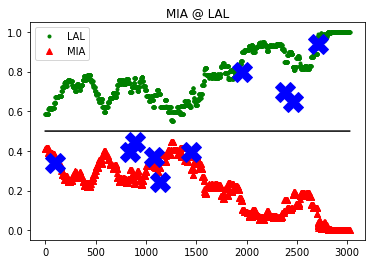

Game important plays: 
Top turning point descriptions: 
With 89.0 seconds left in quarter 3: Dragic 25' 3PT Pullup Jump Shot (10 PTS)
With 0.0 seconds left in quarter 3: Dragic 29' 3PT Step Back Jump Shot (15 PTS)
With 200.0 seconds left in quarter 2: Butler 26' 3PT Step Back Jump Shot (21 PTS) (Adebayo 3 AST)
With 673.0 seconds left in quarter 4: Dragic 27' 3PT Jump Shot (18 PTS) (Robinson 1 AST)
With 614.0 seconds left in quarter 4: Dragic 25' 3PT Pullup Jump Shot (21 PTS) (Olynyk 2 AST)
With 126.0 seconds left in quarter 3: Dragic 11' Driving Floating Jump Shot (7 PTS)
With 168.0 seconds left in quarter 3: Adebayo 1' Alley Oop Dunk (11 PTS) (Dragic 4 AST)
With 595.0 seconds left in quarter 3: Nunn 26' 3PT Jump Shot (11 PTS) (Butler 3 AST)
With 394.0 seconds left in quarter 1: Leonard 25' 3PT Jump Shot (6 PTS) (Adebayo 2 AST)
With 299.0 seconds left in quarter 2: Adebayo REBOUND (Off:1 Def:3)
Done


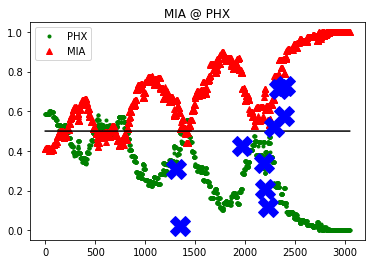

Game important plays: 
Top turning point descriptions: 
With 18.0 seconds left in quarter 1: Winslow 1' Tip Layup Shot (2 PTS)
With 153.0 seconds left in quarter 2: Murray 25' 3PT Pullup Jump Shot (11 PTS)
With 38.0 seconds left in quarter 1: NUGGETS Rebound
With 618.0 seconds left in quarter 3: Jokic 26' 3PT Jump Shot (5 PTS) (Murray 3 AST)
With 107.0 seconds left in quarter 1: Craig  3PT Jump Shot (3 PTS) (Beasley 1 AST)
With 51.0 seconds left in quarter 2: Barton 26' 3PT Jump Shot (12 PTS) (Plumlee 1 AST)
With 69.0 seconds left in quarter 1: Grant  3PT Jump Shot (5 PTS) (Morris 1 AST)
With 268.0 seconds left in quarter 2: Murray 5' Putback Layup (8 PTS)
With 204.0 seconds left in quarter 2: Plumlee 15' Jump Shot (6 PTS) (Barton 2 AST)
With 601.0 seconds left in quarter 1: Leonard Free Throw 1 of 1 (5 PTS)
Done


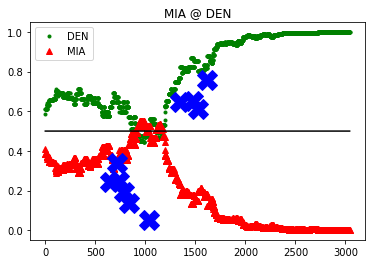

Game important plays: 
Top turning point descriptions: 
With 644.0 seconds left in quarter 1: Gordon Bad Pass Turnover (P1.T2)#@#Adebayo STEAL (1 STL)
With 671.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:1)
With 699.0 seconds left in quarter 1: Westbrook Bad Pass Turnover (P1.T1)#@#Butler STEAL (1 STL)
With 612.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 583.0 seconds left in quarter 1: Harden Bad Pass Turnover (P1.T3)
With 555.0 seconds left in quarter 1: Harden Free Throw 2 of 2 (2 PTS)
With 540.0 seconds left in quarter 1: Butler 26' 3PT Pullup Jump Shot (8 PTS) (Nunn 2 AST)
With 530.0 seconds left in quarter 1: Nunn REBOUND (Off:0 Def:1)
With 432.0 seconds left in quarter 1: Butler REBOUND (Off:1 Def:1)
With 604.0 seconds left in quarter 1: Butler 26' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
Done


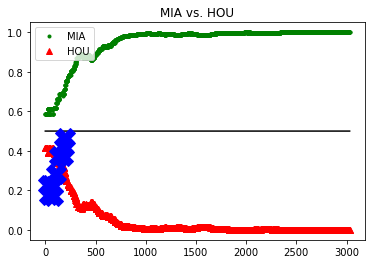

Game important plays: 
Top turning point descriptions: 
With 585.0 seconds left in quarter 4: Parker 1' Tip Dunk Shot (19 PTS)
With 566.0 seconds left in quarter 4: Herro 24' 3PT Jump Shot (13 PTS) (Olynyk 1 AST)
With 579.0 seconds left in quarter 3: Len 1' Putback Dunk (5 PTS)
With 620.0 seconds left in quarter 4: Dragic Free Throw 1 of 2 (4 PTS)
With 328.0 seconds left in quarter 4: Leonard 27' 3PT Pullup Jump Shot (13 PTS) (Butler 9 AST)
With 1.0 seconds left in quarter 3: Herro 25' 3PT Pullup Jump Shot (10 PTS) (Dragic 3 AST)
With 705.0 seconds left in quarter 3: Robinson  3PT Jump Shot (7 PTS) (Butler 5 AST)
With 504.0 seconds left in quarter 3: Hunter Free Throw 2 of 2 (2 PTS)
With 59.0 seconds left in quarter 1: Collins 1' Putback Dunk (7 PTS)
With 521.0 seconds left in quarter 3: Nunn  3PT Jump Shot (15 PTS) (Butler 7 AST)
Done


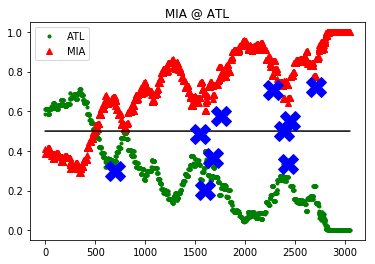

Game important plays: 
Top turning point descriptions: 
With 39.0 seconds left in quarter 2: Herro Free Throw 1 of 3 (19 PTS)
With 597.0 seconds left in quarter 2: Herro  3PT Jump Shot (3 PTS) (Dragic 2 AST)
With 181.0 seconds left in quarter 2: Nunn 24' 3PT Jump Shot (5 PTS) (Herro 1 AST)
With 59.0 seconds left in quarter 1: Dragic  3PT Step Back Jump Shot (6 PTS)
With 44.0 seconds left in quarter 1: Dragic 27' 3PT Step Back Jump Shot (9 PTS)
With 118.0 seconds left in quarter 1: Dragic 25' 3PT Jump Shot (3 PTS)
With 661.0 seconds left in quarter 3: Nunn  3PT Jump Shot (10 PTS) (Winslow 2 AST)
With 82.0 seconds left in quarter 2: Herro 24' 3PT Jump Shot (17 PTS) (Leonard 2 AST)
With 399.0 seconds left in quarter 2: Herro 17' Jump Shot (10 PTS) (Adebayo 1 AST)
With 269.0 seconds left in quarter 1: Butler  3PT Jump Shot (10 PTS) (Nunn 2 AST)
Done


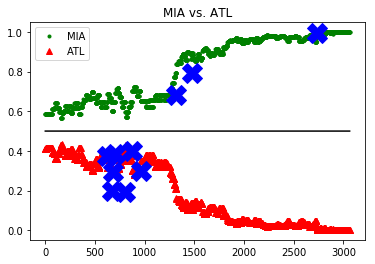

Game important plays: 
Top turning point descriptions: 
With 139.0 seconds left in quarter 4: Wiggins 27' 3PT Jump Shot (22 PTS) (Layman 2 AST)
With 243.0 seconds left in quarter 3: Instant Replay3rd Period (8:46 PM EST)
With 176.0 seconds left in quarter 4: Wiggins 27' 3PT Jump Shot (19 PTS) (Teague 8 AST)
With 195.0 seconds left in quarter 3: Nunn  3PT Jump Shot (25 PTS) (Dragic 3 AST)
With 262.0 seconds left in quarter 4: Wiggins Free Throw 2 of 2 (14 PTS)
With 155.0 seconds left in quarter 3: Dragic  3PT Jump Shot (9 PTS) (Winslow 5 AST)
With 223.0 seconds left in quarter 4: Winslow Free Throw 1 of 2 (16 PTS)
With 368.0 seconds left in quarter 4: Winslow 1' Driving Layup (15 PTS)
With 310.0 seconds left in quarter 4: Robinson  3PT Jump Shot (18 PTS) (Adebayo 5 AST)
With 547.0 seconds left in quarter 3: Adebayo REBOUND (Off:2 Def:4)
Done


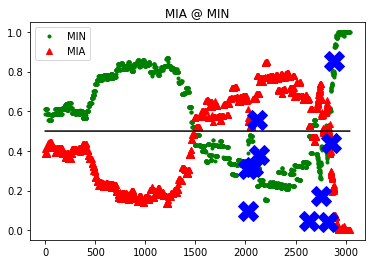

Game important plays: 
Top turning point descriptions: 
With 590.0 seconds left in quarter 2: G. Hill 27' 3PT Jump Shot (5 PTS) (Antetokounmpo 5 AST)
With 503.0 seconds left in quarter 2: Korver 24' 3PT Jump Shot (6 PTS) (Antetokounmpo 7 AST)
With 570.0 seconds left in quarter 2: Matthews  3PT Running Jump Shot (6 PTS) (Antetokounmpo 6 AST)
With 471.0 seconds left in quarter 2: Korver 26' 3PT Jump Shot (9 PTS) (G. Hill 3 AST)
With 392.0 seconds left in quarter 2: Matthews 26' 3PT Jump Shot (9 PTS) (Lopez 1 AST)
With 668.0 seconds left in quarter 2: Lopez 26' 3PT Jump Shot (3 PTS) (Antetokounmpo 4 AST)
With 438.0 seconds left in quarter 1: SUB: G. Hill FOR Bledsoe
With 295.0 seconds left in quarter 2: Lopez 27' 3PT Jump Shot (6 PTS) (Ilyasova 1 AST)
With 214.0 seconds left in quarter 2: Ilyasova 25' 3PT Jump Shot (5 PTS) (Bledsoe 1 AST)
With 424.0 seconds left in quarter 1: Middleton 26' 3PT Jump Shot (11 PTS) (G. Hill 1 AST)
Done


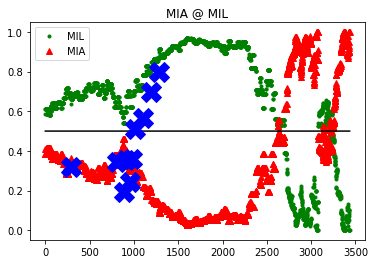

Game important plays: 
Top turning point descriptions: 
With 308.0 seconds left in quarter 3: Dragic 27' 3PT Jump Shot (9 PTS)
With 6.0 seconds left in quarter 2: SUB: Silva FOR Olynyk
With 611.0 seconds left in quarter 4: Winslow 9' Turnaround Fadeaway (21 PTS)
With 705.0 seconds left in quarter 4: Allen 5' Driving Floating Jump Shot (2 PTS) (Morant 4 AST)
With 125.0 seconds left in quarter 3: Jones 14' Pullup Jump Shot (13 PTS) (Allen 2 AST)
With 581.0 seconds left in quarter 4: Silva 2' Layup (2 PTS)
With 414.0 seconds left in quarter 2: Robinson 24' 3PT Jump Shot (3 PTS) (Winslow 4 AST)
With 532.0 seconds left in quarter 4: Silva 2' Alley Oop Dunk (4 PTS) (Dragic 3 AST)
With 330.0 seconds left in quarter 3: Nunn 4' Driving Finger Roll Layup (13 PTS)
With 330.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 2 Short 0)
Done


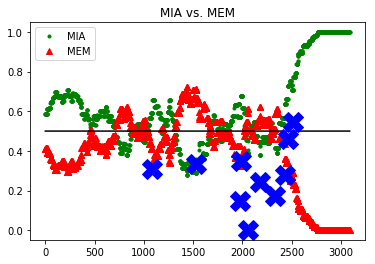

In [75]:
generate_win_probability_team('MIA')